# Phase Estimation

## Overview

- Type: Estimation task
- Time complexity: $O(1/\epsilon)$ for most algorithms, with estimation error $\epsilon$. 
- Approachability: Medium
- Related topics: Phase kickback, Shor's algorithm, Optical interferometry, Quantum Fourier Transform
- Applications: Factoring, eigenvalue estimation, solving linear systems, amplitude estimation, quantum mechanics

In the context of quantum computing, *phase estimation* refers to the problem of estimating of the eigenvalue of a unitary operator given an eigenvector. Algorithms which solve this problem are known as *phase estimation algorithms*. Often in practice, *phase estimation* is used to refer either to the problem or the algorithm interchangeably. 

## Problem statement

For a unitary operation $U$, and associated eigenvector $\vert u \rangle$, there is a $\theta \in [0,1)$ such that

$$
U \vert u \rangle = e^{2\pi i \theta} \vert u \rangle.
$$

Given oracular access to a unitary $U$, controlled versions thereof, and an eigenvector $\vert u \rangle$ prepared on a quantum register to fidelity $F$, determine $\theta$ to accuracy $\epsilon$. We refer to $\theta$ as the *phase*. 

## Algorithms

There are many Quantum Phase Estimation Algorithms (QPEA). In this article we will focus on the following incomplete list.  

- Standard QPEA
- QPEA via Hadamard Test
- Kitaev QPEA
- Fast QPEA (Svore, Hastings, Freedman)
- Bayesian QPEA 

### High level description

Phase estimation algorithms (PEAs) employ phase kickback and quantum interference to measure the desired phase $\theta$ on an auxiliary quantum register. Various degrees of classical post processing are required following the interference measurements. PEAs can be broadly categorized as non-iterative or iterative. Standard phase estimation is the best known of the non-iterative algorithms and requires no classical processing. Iterative PEAs typically use only a single auxiliary qubit and require multiple rounds, sometimes adaptive, and might require significant classical computation.

All but the simplest PEAs achieve a $O(1/\epsilon)$ scaling in accuracy, which is provably optimal in the general setting.

## Standard Phase Estimation Algorithm (Nielsen and Chuang)

### Overview

As the name suggests, the most commonly referred to algorithm for phase estimation, often simply abbreviated to "phase estimation." In contrast to "iterative" methods, this approach requires (with high probability) only one execution of the circuit below, but a number of auxiliary qubits proportional to the desired bits of precision. An $n$ bit approximation is of the phase is produced on an auxiliary register.

### Characteristics

Type: Single shot \
Qubit overhead: $O(\log(1/\epsilon) + \log(1/\delta))$. \
Runtime: $O(1/\epsilon)$ calls to the controlled-$U$. \
Maximum depth: $O(1/\epsilon)$
Works with superposition input?: Yes


### Circuit diagram

### Pseudocode (Nielsen and Chuang pg. 235)

### Qiskit Implementation

In [ ]:
import numpy as np

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import QFT


def create_qpe_circuit(theta, num_qubits):
    """Creates a QPE circuit given theta and num_qubits."""

    # Step 1: Create a circuit with two quantum registers and one classical register.
    first = QuantumRegister(
        size=num_qubits, name="first"
    )  # the first register for phase estimation
    second = QuantumRegister(
        size=1, name="second"
    )  # the second register for storing eigenvector |psi>
    classical = ClassicalRegister(
        size=num_qubits, name="readout"
    )  # classical register for readout
    qpe_circuit = QuantumCircuit(first, second, classical)

    # Step 2: Initialize the qubits.
    # All qubits are initialized in |0> by default, no extra code is needed to initialize the first register.
    qpe_circuit.x(
        second
    )  # Initialize the second register with state |psi>, which is |1> in this example.

    # Step 3: Create superposition in the first register.
    qpe_circuit.barrier()  # Add barriers to separate each step of the algorithm for better visualization.
    qpe_circuit.h(first)

    # Step 4: Apply a controlled-U^(2^j) black box.
    qpe_circuit.barrier()
    for j in range(num_qubits):
        qpe_circuit.cp(
            theta * 2 * np.pi * (2**j), j, num_qubits
        )  # Theta doesn't contain the 2 pi factor.

    # Step 5: Apply an inverse QFT to the first register.
    qpe_circuit.barrier()
    qpe_circuit.compose(QFT(num_qubits, inverse=True), inplace=True)

    # Step 6: Measure the first register.
    qpe_circuit.barrier()
    qpe_circuit.measure(first, classical)

    return qpe_circuit

## Phase Estimation with the Hadamard test

#### Overview 

The Hadamard test serves as a phase estimation algorithm. See the Hadamard Test article for further information.

#### Characteristics

Type: Iterative \
Qubit overhead: $1$ ancilla \
Runtime: $O(1/\epsilon^2)$ iterations. \
Eigenvector superpositions: Yes for coherent, No otherwise \
Maximum depth: $O(1)$ for incoherent, $O(1/\epsilon^2)$ for coherent.

#### Remarks

Possibly the simplest QPEA, but with quadratically worse scaling than other approaches in the accuracy. Low overhead qubit costs make this approach more attractive than standard QPE for noisy hardware. Two versions of this exist: a "coherent" version, in which repeated measurements 

### Qiskit Implementation

#### Relevant imports

In [64]:
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit_aer.primitives import Sampler
from qiskit.circuit.library.standard_gates import SwapGate

#### Basic Hadamard circuit

The code below is borrowed from the Hadamard test compendium article. See that page for further details.

In [3]:
def hadamard_circuit(U, add_s_gate=False, measure=True):
    """
    Args:
        U (Gate): Unitary gate to measure expectation value of
        add_s_gate (bool): Whether to measure real (False) or imaginary
            (True) parts of the expectation value
        measure (bool): Whether to measure the auxiliary qubit
    Returns:
        QuantumCircuit that implements the Hadamard test
    """
    # Initialize registers and circuit
    aux = QuantumRegister(1, 'aux')
    main = QuantumRegister(U.num_qubits, 'q')
    circuit = QuantumCircuit(aux, main)
    
    # Construct controlled-U gate
    cU = U.control(1)
    
    # Add gates to circuit
    circuit.h(aux)
    circuit.append(cU, aux[:] + main[:])
    if add_s_gate:
        circuit.s(aux)
    circuit.h(aux)
    
    # Add measurement if option specified
    if measure:
        creg = ClassicalRegister(1, 'c')
        circuit.add_register(creg)
        circuit.measure(aux, creg)
    
    return circuit

#### Coherent vs incoherent phase estimation

Hadamard phase estimation involves repeated Hadamard circuit measurements. There are two approaches we can take:

- Perform a Hadamard test on many copies of identical input states. We label this "incoherent" phase estimation. This approach only works when the state is approximately an eigenstate, but uses shallower circuits. 
- After each Hadamard test measurement, leave the state of the main register as is. This corresponds to "coherent" phase estimation. This approach allows for phase estimation with generic input states, with probability of a phase being measured given by the Born rule. However, this approach has larger circuit depths.

The following function creates the required circuit for coherent phase estimation.

In [4]:
# State of main register is not reset after each measurement. Allows for phase estimation over superpositions.
def coherent_Hadamard_circuit(U, Ncycles):
    """
    Args:
        U (Gate): Unitary gate to measure
        Ncycles: Number of measurements on ancilla qubit for phased and unphased Hadamard test. 
        coherent (bool): Whether to keep state of principal register (True) 
            or reset to original state(False) after each measurement.
    Returns:
        QuantumCircuit that implements a coherent version of the Hadamard test, whereby this we mean the state of the principal register is not reset following measurements.
    """
    hadamard_circ = hadamard_circuit(U, add_s_gate = False, measure = True)
    
    
    # Initialize circuit with first iteration as initial fencepost
    circuit = hadamard_circuit(U, add_s_gate = False, measure = False)
    creg = ClassicalRegister(2*Ncycles, 'c')
    circuit.add_register(creg)
    circuit.measure(0, creg[0])
    circuit.reset(0)
    
    # Perform nonphased measurements
    for k in range(1, Ncycles):
        circuit = circuit.compose(hadamard_circ, qubits = None, clbits = k)
        circuit.reset(0)
        
    hadamard_circ = hadamard_circuit(U, add_s_gate = True, measure = True)
    
    # Perform nonphased measurements
    for k in range(0, Ncycles):
        circuit = circuit.compose(hadamard_circ, qubits = None, clbits = k + Ncycles)
        circuit.reset(0)
    
    return circuit

We demonstrate this construction for $U = \text{SWAP}$.

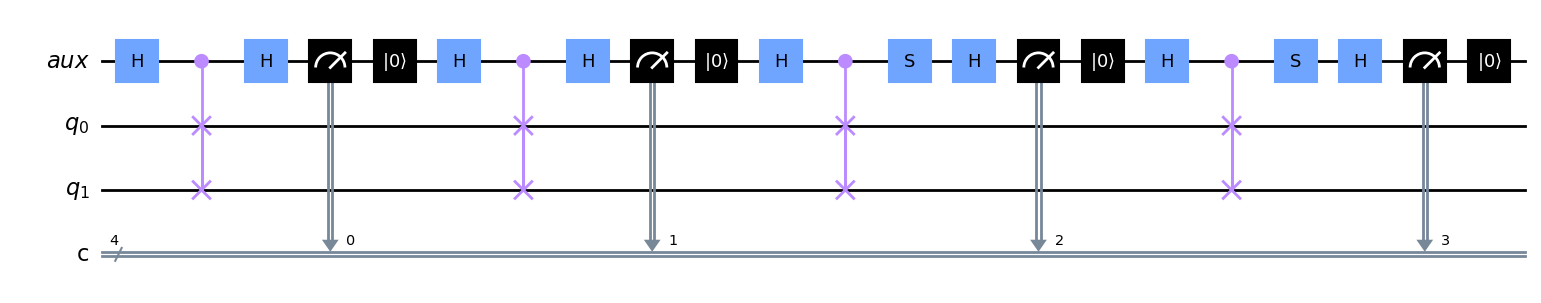

In [5]:
circuit = coherent_Hadamard_circuit(SwapGate(), 2)
circuit.draw(output = 'mpl')

Using `Ncycles = 2` is typically too short to get a good estimate, but we wanted to make the circuit easy to visualize. 

#### Hadamard phase estimation.

Below is a function to perform Hadamard phase estimation, either coherent or incoherent. 

In [90]:
def Hadamard_phase_estimation(U, Uprep = None, precision = 2 * 10**-1, coherent = False):
    """
    Args:
        U (Gate): Unitary gate to measure expectation value of
        backend (Backend): Desired Qiskit backend, such as a simulator or quantum device
        precision (float): Desired precision of phase. 
            Achieving results well outside of precision has exponentially vanishing probability. 
        coherent (bool): Whether to keep state of principal register (True) 
            or reset to original state(False) after each measurement.
    Returns:
        An estimate for the phase with specified precision, to confidence ~70%.
            Large deviations from precision are statistically unlikely.
    """
    Ncycles = int(2//(precision**2))
    
    # Do single shot, coherent phase estimation if coherent = True
    if coherent:
        phase_estimation_circuit = coherent_Hadamard_circuit(U, Ncycles)
        # Perform state prep, if any
        if Uprep != None: phase_estimation_circuit.compose(Uprep, front = True)
        # Run circuit
        job = Sampler().run(circuit, shots = 1)
        result_dict = job.result().quasi_dists[0]
        measurements = bin(list(result_dict)[0])[2:]
        
        # Split results into phased and unphased measurements
        phased_measurements = measurements[0:Ncycles]
        unphased_measurements = measurements[Ncycles, 2*Ncycles]
        
        # Compute Hamming weight to get counts
        phased_counts = np.sum(list(map(int,list(phased_measurements))))
        unphased_counts = np.sum(list(map(int,list(unphased_measurements))))
        
        # Extract Pr(0)
        unphased_p0 = 1 - unphased_counts/Ncycles
        phased_p0 = 1 - phased_counts/Ncycles
    else:  
        # Otherwise, do incoherent phase estimation
        unphased_circuit = hadamard_circuit(U, add_s_gate = False, measure = True)
        phased_circuit = hadamard_circuit(U, add_s_gate = True, measure = True)
        # Do state prep, if any
        if Uprep != None:
            unphased_circuit = unphased_circuit.compose(Uprep, range(1,unphased_circuit.num_qubits),front = True)
            phased_circuit = phased_circuit.compose(Uprep, range(1,unphased_circuit.num_qubits), front = True)

        # Run circuits
        unphased_results = Sampler().run(unphased_circuit, shots = Ncycles).result().quasi_dists[0]
        phased_results = Sampler().run(phased_circuit, shots = Ncycles).result().quasi_dists[0]

        # Extract Pr(0)
        unphased_p0 = unphased_results.get(0, 0)
        phased_p0 = phased_results.get(0, 0)

    
    # Get cosine and sine of phase
    costheta = 2*unphased_p0 - 1
    sintheta = 1- 2*phased_p0
    
    #Extract phase as final result
    theta = np.arctan2(sintheta, costheta)
    # Make branch correction to [0, 2 pi)
    if theta < 0: theta += 2*np.pi
    # Return number between 0,1
    theta = theta/(2*np.pi)
    return theta

Example, SWAP gate

In [99]:
# Prepare a symmetric eigenstate of SWAP. Phase should be zero or 2 pi.
prep_circuit = QuantumCircuit(2)
prep_circuit.h(0)
prep_circuit.cx(0,1)
prep_circuit.x(0)

Uprep = prep_circuit.to_gate()

phase = Hadamard_phase_estimation(SwapGate(), Uprep, precision = 2 * 10**-1, coherent = False)

### Kitaev Phase Estimation Algorithm

#### Overview

The Kitaev phase estimation algorithm (KPEA) is simply the Hadamard test repeated with certain multiples of the phase, followed by classical post processing on the resulting data. More specifically, instead of estimating 

#### Characteristics

Type: Iterative \
Qubit overhead: $1$ ancilla \
Runtime: $O(1/\epsilon)$ \
Eigenvector superpositions?: No

#### Circuit diagram

#### Pseudocode

### Qiskit Implementation

In [ ]:
import numpy as np


## Applications
- Order finding, thereby integer factorization (Shor's algorithm)
- Solving linear systems of equations (HHL algorithm)
- Quantum simulation

### See also

- 

In [3]:
import qiskit_aer
qiskit_aer.version.get_version_info()

'0.11.0'